In [1]:
import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

import missingno as msno

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from catboost import CatBoostClassifier

%matplotlib inline

import warnings
warnings.simplefilter('ignore')

##### Отчет по метрикам:

In [2]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

##### График для выбора границы принятия решения:

In [3]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [4]:
DATASET_PATH = 'data/course_project_train.csv'
TEST_DATASET_PATH = 'data/course_project_test.csv'
PREP_DATASET_PATH = 'data/course_project_train_prep.csv'
MODEL_FILE_PATH = 'models/model.pkl'

# 1. Анализ данных

In [5]:
df = pd.read_csv(DATASET_PATH)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [7]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [8]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

<AxesSubplot:>

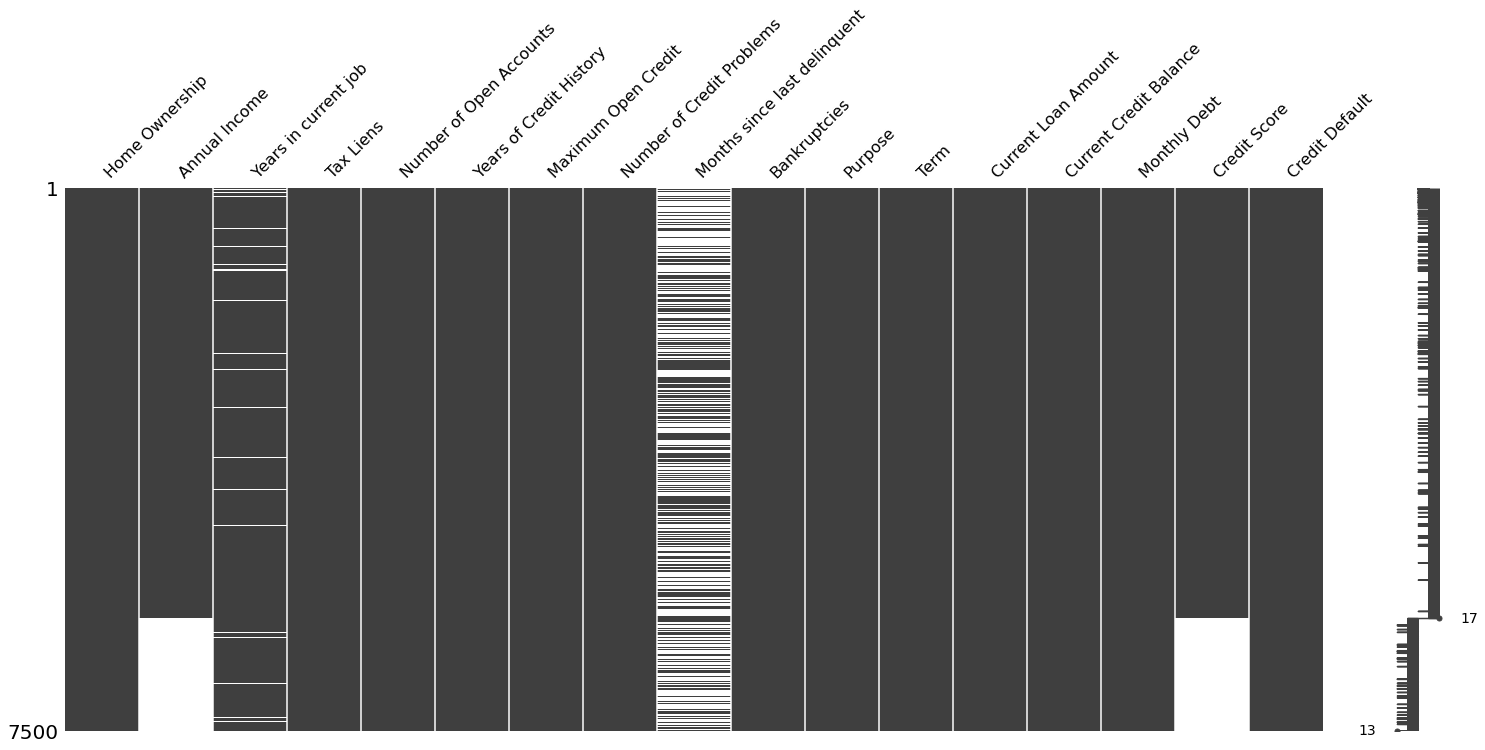

In [9]:
msno.matrix(df.sort_values('Annual Income'))

Для объектов с пропусками не увидел характеристик, которые помогли бы помочь восстановить значения. Буду заполнять медианами, модами и т.п. 
* **Credit Score** часто имеет очень большие значения. И во всех этих случаях Credit Default = 1. Можно попробовать добавить категориальный признак, обозначающий огромный рейтинг, а выбросы обработать.
* **Current Loan Amount** тоже принимает огормные значения (все девятки). И такие объекты не отличаются от остальных.

In [10]:
df[df['Credit Score'] > 1000]['Credit Default'].value_counts()

1    400
Name: Credit Default, dtype: int64

In [11]:
df.loc[df['Annual Income'].isna(), 'Annual Income'] = df['Annual Income'].median()
df.loc[df['Months since last delinquent'].isna(), 'Months since last delinquent'] = df['Months since last delinquent'].median()

df.loc[df['Credit Score'].isna(), 'Credit Score'] = df['Credit Score'].median()
df['Large_Score'] = 0
df.loc[df['Credit Score']>1000, 'Large_Score'] = 1
df = df.astype({'Large_Score': 'object'})
df.loc[df['Credit Score']>1000, 'Credit Score'] = df[df['Credit Score']<1000]['Credit Score'].max()

df.loc[df['Current Loan Amount']>4000000, 'Current Loan Amount'] = df[df['Current Loan Amount']<4000000]['Current Loan Amount'].mean()

df.loc[df['Bankruptcies'].isna(), 'Bankruptcies'] = df['Bankruptcies'].mode()[0]
df.loc[df['Years in current job'].isna(), 'Years in current job'] = df['Years in current job'].mode()[0]

In [12]:
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

* **Home Ownership**.
Тут две крупные группы: ипотечники и арендаторы. Есть так же владельцы жилья, их можно попробовать объединить с кем-то. Скорее с ипотечниками, чем с арендаторами. И те и другие пользуются площадью, могут сдавать ее в аренду арендаторам.
* **Purpose**.
Видим, что большая часть кредитов идет на обеспечение **уже имеющихся кредитных обязательств**. Это гиблое дело. Оставлю две категории: debt consolidation и not debt consolidation
* **Years in current job**.
Вероятно, категорий слишком много, и нет большой разницы между длительностью 7 и 8 лет, например.

In [13]:
df['Home_Ownership'] = 1
df.loc[df['Home Ownership']=='Rent', 'Home_Ownership'] = 0

df['Debt_Consolidation'] = 0
df.loc[df['Purpose']=='debt consolidation', 'Debt_Consolidation'] = 1

df['Years_in_current_job'] = 1
df.loc[df['Years in current job'].isin(['2 years', '3 years', '4 years']), 'Years_in_current_job'] = 2
df.loc[df['Years in current job'].isin(['5 years', '6 years', '7 years']), 'Years_in_current_job'] = 3
df.loc[df['Years in current job'].isin(['8 years', '9 years', '10+ years']), 'Years_in_current_job'] = 4

df = df.astype({'Home_Ownership': 'object', 'Debt_Consolidation': 'object', 'Years_in_current_job': 'object'})
df.drop(['Home Ownership', 'Purpose', 'Years in current job'], axis=1, inplace=True)

In [14]:
df['Bankruptcies'].value_counts()

0.0    6674
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

**Bankruptcies**. Огромная группа без банкротств. Оставляем две категории, не важно сколько было банкроств

In [15]:
df['Months since last delinquent'].value_counts()

32.0     4132
14.0       76
29.0       71
33.0       68
8.0        68
         ... 
86.0        1
118.0       1
84.0        1
91.0        1
92.0        1
Name: Months since last delinquent, Length: 89, dtype: int64

In [16]:
df['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

**Number of Credit Problems**. Опять же две категории. Были проблемы или нет.

In [17]:
df['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64

**Tax Liens**. Оставляем две категории

In [18]:
df['Number of Open Accounts'].value_counts()

9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
32.0      6
33.0      6
31.0      6
34.0      2
37.0      2
43.0      1
41.0      1
38.0      1
35.0      1
42.0      1
Name: Number of Open Accounts, dtype: int64

In [19]:
df['Credit Problems'] = 1
df.loc[df['Number of Credit Problems']==0, 'Credit Problems'] = 0

df['Bankruptcies_'] = 1
df.loc[df['Bankruptcies']==0, 'Bankruptcies_'] = 0

df['Tax_Liens'] = 1
df.loc[df['Tax Liens']==0, 'Tax_Liens'] = 0

df = df.astype({'Credit Problems': 'object', 'Bankruptcies_': 'object', 'Tax_Liens': 'object'})
df.drop(['Number of Credit Problems', 'Bankruptcies', 'Tax Liens'], axis=1, inplace=True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 7500 non-null   float64
 1   Number of Open Accounts       7500 non-null   float64
 2   Years of Credit History       7500 non-null   float64
 3   Maximum Open Credit           7500 non-null   float64
 4   Months since last delinquent  7500 non-null   float64
 5   Term                          7500 non-null   object 
 6   Current Loan Amount           7500 non-null   float64
 7   Current Credit Balance        7500 non-null   float64
 8   Monthly Debt                  7500 non-null   float64
 9   Credit Score                  7500 non-null   float64
 10  Credit Default                7500 non-null   int64  
 11  Large_Score                   7500 non-null   object 
 12  Home_Ownership                7500 non-null   object 
 13  Deb

Text(0.5, 1.0, 'Корреляция признаков')

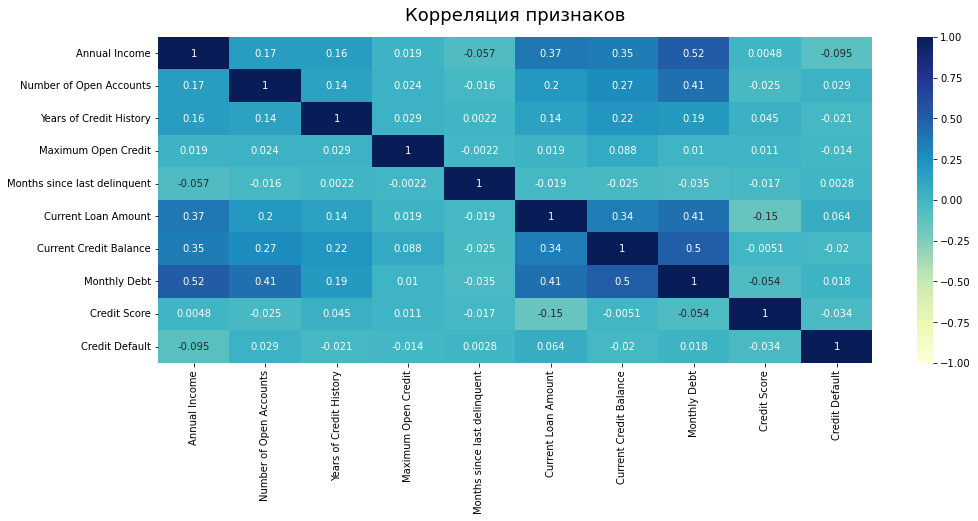

In [21]:
plt.figure(figsize=(16, 6)) 

heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='YlGnBu') 
heatmap.set_title('Корреляция признаков', fontdict={'fontsize':18}, pad=16)

In [22]:
df.to_csv(PREP_DATASET_PATH, encoding='utf-8', index=False)

##### Класс для подготовки данных:

In [23]:
class DataPreparation():
    
    def __init__(self):
        
        self.medians = None
        self.modes = None
        self.max_credit_score = None
        self.current_loan_ammount = None
        
        
    def fit(self, df):
        
        self.medians = df.median()
        self.modes = df.mode()
        self.max_credit_score = df[df['Credit Score']<1000]['Credit Score'].max()
        self.mean_current_loan_ammount = df[df['Current Loan Amount']<4000000]['Current Loan Amount'].mean()
        
        
    def transform(self, df):
        
        df.copy()
        
        df.loc[df['Annual Income'].isna(), 'Annual Income'] = self.medians['Annual Income']
        df.loc[df['Months since last delinquent'].isna(), 'Months since last delinquent'] = self.medians['Months since last delinquent']
        df.loc[df['Credit Score'].isna(), 'Credit Score'] = self.medians['Credit Score']
        
        df['Large_Score'] = 0
        df.loc[df['Credit Score']>1000, 'Large_Score'] = 1
        df.loc[df['Credit Score']>1000, 'Credit Score'] = self.max_credit_score
        
        df.loc[df['Current Loan Amount']>4000000, 'Current Loan Amount'] = self.mean_current_loan_ammount
        
        df.loc[df['Bankruptcies'].isna(), 'Bankruptcies'] = self.modes['Bankruptcies'][0]
        
        df.loc[df['Years in current job'].isna(), 'Years in current job'] = self.modes['Years in current job'][0]
        
        df['Home_Ownership'] = 1
        df.loc[df['Home Ownership']=='Rent', 'Home_Ownership'] = 0
        
        df['Debt_Consolidation'] = 0
        df.loc[df['Purpose']=='debt consolidation', 'Debt_Consolidation'] = 1
        
        df['Years_in_current_job'] = 1
        df.loc[df['Years in current job'].isin(['2 years', '3 years', '4 years']), 'Years_in_current_job'] = 2
        df.loc[df['Years in current job'].isin(['5 years', '6 years', '7 years']), 'Years_in_current_job'] = 3
        df.loc[df['Years in current job'].isin(['8 years', '9 years', '10+ years']), 'Years_in_current_job'] = 4
        
        df['Credit Problems'] = 1
        df.loc[df['Number of Credit Problems']==0, 'Credit Problems'] = 0

        df['Bankruptcies_'] = 1
        df.loc[df['Bankruptcies']==0, 'Bankruptcies_'] = 0

        df['Tax_Liens'] = 1
        df.loc[df['Tax Liens']==0, 'Tax_Liens'] = 0
        
        df = df.astype({'Home_Ownership': 'object', 'Debt_Consolidation': 'object', 'Years_in_current_job': 'object', \
                        'Large_Score': 'object', 'Credit Problems': 'object', 'Bankruptcies_': 'object', 'Tax_Liens': 'object'})
        
        df.drop(['Home Ownership', 'Purpose', 'Years in current job', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens'], axis=1, inplace=True)
        
        df.fillna(self.medians, inplace=True)
        
        return df
        

In [24]:
CAT_FEATURE_NAMES = ['Term', 'Large_Score','Home_Ownership','Debt_Consolidation','Years_in_current_job','Credit Problems', \
                    'Bankruptcies_','Tax_Liens']

NUM_FEATURE_NAMES = ['Annual Income','Number of Open Accounts','Years of Credit History','Maximum Open Credit', \
                    'Months since last delinquent','Current Loan Amount','Current Credit Balance','Monthly Debt','Credit Score']

TARGET_NAME = 'Credit Default'

# 2. Обучение моделей

In [25]:
df = pd.read_csv(DATASET_PATH)

X = df.drop(columns=TARGET_NAME)
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=31)

In [26]:
data_prep = DataPreparation()

data_prep.fit(X_train)

X_train = data_prep.transform(X_train)
X_test = data_prep.transform(X_test)

X_train.shape, X_test.shape

((5250, 17), (2250, 17))

##### Далее обучаю модель. Вижу, что порог принятий решений 0,5 не подходит. Выбираю оптимальный порог, но модель переобучена.

In [27]:
catboost = CatBoostClassifier(silent=True,
                              iterations=700,
                              depth=4,
                              l2_leaf_reg=11,
                              learning_rate=0.025,
                              grow_policy= 'Lossguide',
                              max_leaves = 70,
                              random_state=21)
catboost.fit(X_train, y_train, cat_features=CAT_FEATURE_NAMES)

In [28]:
y_train_pred = catboost.predict(X_train)
y_test_pred = catboost.predict(X_test)
y_train_pred_probs = catboost.predict_proba(X_train)
y_test_pred_probs = catboost.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.99      0.89      3785
           1       0.94      0.41      0.57      1465

    accuracy                           0.83      5250
   macro avg       0.88      0.70      0.73      5250
weighted avg       0.85      0.83      0.80      5250

TEST

              precision    recall  f1-score   support

           0       0.77      0.96      0.86      1602
           1       0.76      0.30      0.43       648

    accuracy                           0.77      2250
   macro avg       0.77      0.63      0.64      2250
weighted avg       0.77      0.77      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1542   60
1                455  193


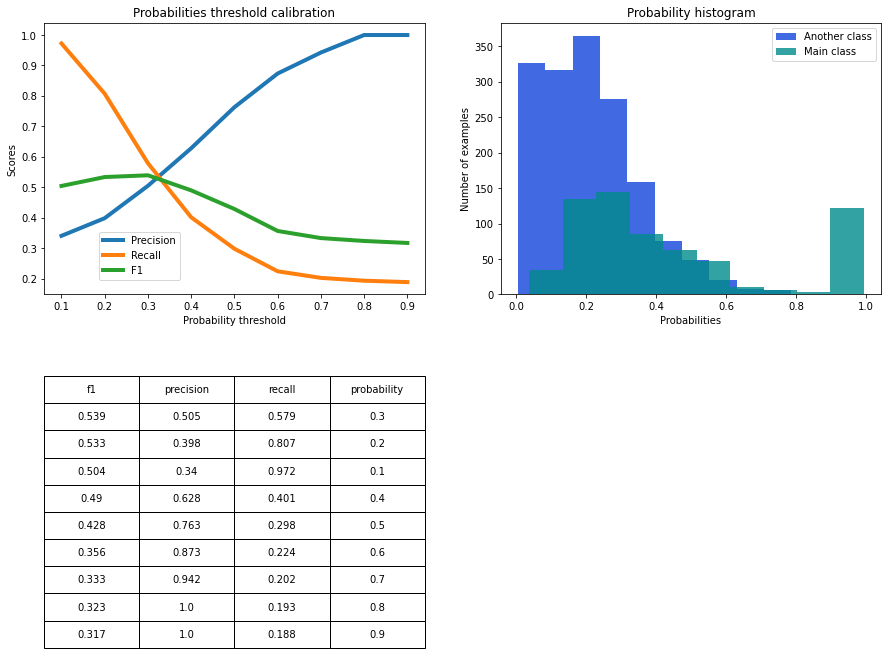

In [29]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [30]:
pred_test = np.array([1 if val > 0.30 else 0 for val in y_test_pred_probs[:,1]])
pred_train = np.array([1 if val > 0.30 else 0 for val in y_train_pred_probs[:,1]])

In [31]:
get_classification_report(y_train, pred_train, y_test, pred_test)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.85      0.88      3785
           1       0.67      0.77      0.72      1465

    accuracy                           0.83      5250
   macro avg       0.79      0.81      0.80      5250
weighted avg       0.84      0.83      0.83      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.77      0.79      1602
           1       0.50      0.58      0.54       648

    accuracy                           0.72      2250
   macro avg       0.66      0.67      0.67      2250
weighted avg       0.73      0.72      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1234  368
1                273  375


##### Выбираю оптимальные параметры для избежания переобучения модели. Получаю приемлемый результат

In [32]:
catboost_final = CatBoostClassifier(silent=True,
                              iterations=200,
                              depth=3,
                              l2_leaf_reg=7,
                              learning_rate=0.01,
                              grow_policy= 'Lossguide',
                              max_leaves = 100,
                              random_state=111)
catboost_final.fit(X_train, y_train, cat_features=CAT_FEATURE_NAMES)

In [33]:
y_train_pred = catboost_final.predict(X_train)
y_test_pred = catboost_final.predict(X_test)
y_train_pred_probs = catboost_final.predict_proba(X_train)
y_test_pred_probs = catboost_final.predict_proba(X_test)

pred_test = np.array([1 if val > 0.29 else 0 for val in y_test_pred_probs[:,1]])
pred_train = np.array([1 if val > 0.29 else 0 for val in y_train_pred_probs[:,1]])

get_classification_report(y_train, pred_train, y_test, pred_test)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      3785
           1       0.52      0.55      0.54      1465

    accuracy                           0.73      5250
   macro avg       0.67      0.68      0.67      5250
weighted avg       0.74      0.73      0.74      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.79      0.80      1602
           1       0.52      0.57      0.54       648

    accuracy                           0.72      2250
   macro avg       0.67      0.68      0.67      2250
weighted avg       0.73      0.72      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1263  339
1                280  368


In [34]:
catboost_final.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Large_Score,70.755899
1,Current Loan Amount,10.779937
2,Credit Score,8.557765
3,Term,4.130540
4,Annual Income,3.221372
5,Maximum Open Credit,0.599759
6,Home_Ownership,0.395875
7,Monthly Debt,0.379080
8,Years of Credit History,0.301305
9,Months since last delinquent,0.270120


##### Учу модель на всех данных. Делаю предсказания для тестовых данных

In [35]:
data_prep.fit(X)
X = data_prep.transform(X)

catboost_final.fit(X, y, cat_features=CAT_FEATURE_NAMES)

with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(catboost_final, file)

In [36]:
df_test = pd.read_csv(TEST_DATASET_PATH)

df_test = data_prep.transform(df_test)

In [37]:
pred_prob = catboost_final.predict_proba(df_test)

y_test = np.array([1 if val > 0.29 else 0 for val in pred_prob[:,1]])

In [38]:
df_test['Credit Default'] = y

In [39]:
df_test['Credit Default'].to_csv('data/NilTimofeev_predictions.csv', encoding='utf-8', index=False)